In [ ]:
pip install transformers datasets torch accelerate peft
pip install kagglehub
pip install matplotlib



SyntaxError: invalid syntax (2185429697.py, line 1)

In [1]:
import kagglehub
import pandas as pd
import os, json, random
from textwrap import dedent
from typing import Dict
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
from sklearn.model_selection import train_test_split

from transformers import AutoModelForCausalLM, TrainingArguments, AutoTokenizer, BitsAndBytesConfig, pipeline
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torch
import re


c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = r"C:\Users\Joshua\Desktop\python_ai\llm_code\llama31\Llama-3.1-8B-Instruct"

# Loading model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
) # INSPECT MORE

llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Tokenizer
special_tokens_dict = {
    "bos_token": "<s>",
    "eos_token": "</s>",
    "pad_token": "<pad>",
    "additional_special_tokens": ["<EQ>", "<EXPL>"]
}

tokenizer = AutoTokenizer.from_pretrained(model_id)
add_special_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

if add_special_tokens > 0:
    llm_model.resize_token_embeddings(len(tokenizer))

# Debug
print("Tokenizer vocabulary size:", len(tokenizer))
print("Model embedding size:", llm_model.get_input_embeddings().weight.size(0))
print("Special tokens:")
print("  BOS token:", tokenizer.bos_token)
print("  EOS token:", tokenizer.eos_token)
print("  PAD token:", tokenizer.pad_token)
print("  Additional special tokens:", tokenizer.additional_special_tokens)

c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\accelerate\utils\modeling.py:841: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  _ = torch.tensor([0], device=i)
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer vocabulary size: 128261
Model embedding size: 128261
Special tokens:
  BOS token: <s>
  EOS token: </s>
  PAD token: </s>
  Additional special tokens: ['<EQ>', '<EXPL>']


In [3]:
dataset_path = r"C:\Users\Joshua\Desktop\python_ai\llm_code\datasets\pc_build_parts.json"

with open(dataset_path, 'r') as file:
    dataset = json.load(file)


budget_template = "Build me a PC around ${budget}."

def format_parts(parts, float_cost, total):
    result = f"To produce a build under ${float_cost}\n\n"
    for i, part in enumerate(parts, start=1):
        result += f"{i}. **{part['Type']}**: {part['Name']} - {part['Price']}\n"
    result += f"\n**Total Cost:**: ${total}"
    return result

def round_to_nearest_100(value):
    return round(value / 100) * 100

rows = []
for build in dataset:
    description = " ".join(build["Description"])
    parts = build["Part List"]["Parts"]
    total_cost = build["Part List"]["Total"]
    clean_cost = re.sub(r'[^0-9.]', '', total_cost)
    float_cost = float(clean_cost)

    rows.append({
        "question": budget_template.format(budget=round_to_nearest_100(float_cost)),
        "context": f"{description}.",
        "answer": f"{format_parts(parts, float_cost, clean_cost)}"
    })

df = pd.DataFrame(rows)
formatted_output = format_parts(parts, float_cost, clean_cost)
print(formatted_output)

To produce a build under $250.77

1. **CPU**: Intel Core i5-10600KF 4.1 GHz 6-Core Processor - $84.22 USD
2. **Motherboard**: Asus PRIME H410M-E Micro ATX LGA1200 Motherboard - $0.00 USD
3. **Memory**: Corsair Vengeance LPX 16 GB (2 x 8 GB) DDR4-3200 CL16 Memory - $21.82 USD
4. **Storage**: Toshiba DT01ACA200 2 TB 3.5" 7200 RPM Internal Hard Drive - $0.00 USD
5. **Storage**: Western Digital SN530 512 GB M.2-2280 PCIe 3.0 X4 NVME Solid State Drive - $21.82 USD
6. **Video Card**: Asus Phoenix OC GeForce GTX 1660 SUPER 6 GB Video Card - $72.73 USD
7. **Case**: KOLINK OBSERVATORY LITE MESH RGB ATX Mid Tower Case - $21.82 USD
8. **Custom**: ZALMAN's CNPS9X Optima w/White LED Fan - $13.96 USD
9. **Custom**: LogiLink PC0057 PCI Expres Card 4x USB3.0 - $14.40 USD
10. **Custom**: Energon EP​​S-750W IT​E​M NO.: 8​88​82021 -                                     $0.00 USD
                                

**Total Cost:**: $250.77


In [4]:
df.isnull().value_counts()
df

,question,context,answer
0,Build me a PC around $1300.,My Sons 1st Build.. used for school and some g...,To produce a build under $1284.46\n\n1. **CPU*...
1,Build me a PC around $2500.,My first gaming pc in 8 years and first ever s...,To produce a build under $2520.0\n\n1. **CPU**...
2,Build me a PC around $4200.,Built the quietest gaming PC with an AMD Ryzen...,To produce a build under $4160.52\n\n1. **CPU*...
3,Build me a PC around $600.,This is the product of some parts swaps for a ...,To produce a build under $571.96\n\n1. **CPU**...
4,Build me a PC around $4900.,Decided to upgrade form the 13900k to 14900kf....,To produce a build under $4949.51\n\n1. **CPU*...
...,...,...,...
119315,Build me a PC around $6200.,Gaming..,To produce a build under $6241.34\n\n1. **CPU*...
119316,Build me a PC around $3700.,"cat videos at 8k WHO Aside from cat videos, th...",To produce a build under $3714.62\n\n1. **CPU*...
119317,Build me a PC around $200.,After 4 years with the Ryzen 5 2600 and RX 570...,To produce a build under $187.77\n\n1. **CPU**...
119318,Build me a PC around $4100.,Built a PC for my gf and she made it her own. ...,To produce a build under $4102.53\n\n1. **CPU*...


In [5]:
def format_dataset(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role":"system",
            "content": "Use only the information to answer the question",
        },
        {"role":"user", "content": prompt},
        {"role":"assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [6]:
df["text"] = df.apply(format_dataset, axis=1)

In [7]:
def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [8]:
df["token_count"] = df.apply(count_tokens, axis=1)

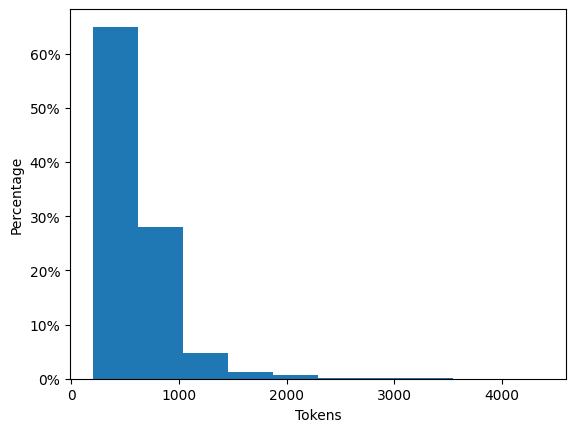

In [9]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show()

In [10]:
# Tell us the length
len(df[df.token_count < 2000]), len(df), len(df[df.token_count < 2100]) / len(df)

(118465, 119320, 0.9939406637613141)

In [11]:
df = df[df.token_count < 2100]
df = df.sample(11000)
df.shape

(11000, 5)

In [13]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

print(f"Train dataset size: {len(train)}")
print(f"Validation dataset size: {len(val)}")
print(f"Test dataset size: {len(test)}")

train.sample(n=8000).to_json("split_sets/train.json", orient="records", lines=True)
val.sample(n=1500).to_json("split_sets/val.json", orient="records", lines=True)
test.sample(n=400).to_json("split_sets/test.json", orient="records", lines=True)

Train dataset size: 8800
Validation dataset size: 1760
Test dataset size: 440


In [14]:
# Finetune Below
print(train.head())

                           question  \
118530  Build me a PC around $2600.   
101161  Build me a PC around $3000.   
107552  Build me a PC around $1300.   
18825   Build me a PC around $1400.   
81276   Build me a PC around $1400.   

                                                  context  \
118530  Upgraded my last build with NZXT Kraken Elite ...   
101161  First time building a PC from scratch. I decid...   
107552  mainly gaming orientated with light useage of ...   
18825   1k+ frames for modded minecraft so no complain...   
81276   Built this for a friend's sons Xmas gift. Have...   

                                                   answer  \
118530  To produce a build under $2613.65\n\n1. **CPU*...   
101161  To produce a build under $2999.62\n\n1. **CPU*...   
107552  To produce a build under $1250.39\n\n1. **CPU*...   
18825   To produce a build under $1421.66\n\n1. **CPU*...   
81276   To produce a build under $1399.77\n\n1. **CPU*...   

                               

In [15]:
dataset = load_dataset(
    "json",
    data_files={"train": "split_sets/train.json", "validation": "split_sets/val.json", "test": "split_sets/test.json"},
)
print(dataset["train"][0]["text"])

Generating train split: 8000 examples [00:00, 90911.49 examples/s]
Generating validation split: 1500 examples [00:00, 124994.16 examples/s]
Generating test split: 400 examples [00:00, 50018.53 examples/s]


<s><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

Build me a PC around $2800.

Information:

```
Based PC for gaming and such..
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

To produce a build under $2829.55

1. **CPU**: Intel Core i7-13700K 3.4 GHz 16-Core Processor - $301.69 USD
2. **Thermal Compound**: Arctic Silver 5 High-Density Polysynthetic Silver 12 g Thermal Paste - $26.00
3. **Motherboard**: Asus ROG STRIX Z690-E GAMING WIFI ATX LGA1700 Motherboard - $180.36 USD
4. **Memory**: Corsair Vengeance RGB 32 GB (2 x 16 GB) DDR5-6200 CL36 Memory - $209.00
5. **Storage**: Samsung 850 Evo 500 GB 2.5" Solid State Drive - None
6. **Storage**: Samsung 860 QVO 1 TB 2.5" Solid State Drive - $183.59
7. **Storage**: Samsung 970 Evo Plus 1 TB M.2-2280 PCIe 3.0 X4 NVME Solid State Drive - $99.00
8. **Storage**: Samsung 970 E

In [16]:
# Pipeline for taking in inputs
# del pipeline

pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    return_full_text=False,
    model_kwargs={"torch_dtype": torch.bfloat16},
    #device="cuda",
)

In [18]:
def create_test_prompt(data_row):
    prompt = dedent(
        f"""
    {data_row["question"]}

    Information:

    ```
    {data_row["context"]}
    ```
    """
    )
    messages = [
        {
            "role":"system",
            "content": "Use only the information to answer the question",
        },
        {"role":"user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [19]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<s><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

Build me a PC around $3000.

Information:

```
From HotPink to Black Out! Featuring Carbon fibre suspension support struts, custom mounting hardware for all the radiators and Bitspower's new Stealth Waterblock in collaboration with Modding Cafe. The full build took close to 1.5 months and as usualy i'd like to thank all the support from our sponsors Asrock, Antec, Kingston Technology, Bitspower, Monster studio, Mayhems Solutions and RCPC. This build combo is abit of a monster, running a 4090 Founders Edition Graphics Card, 13700k and 8000mt/s CL36 DDR5 Memory. It was also a great honour yesterday to showcase the build with Antec at the Target Open Day trade show to represent them on their stand.  Thank you!.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
%%time
outputs = pipeline(
    prompt, 
    max_new_tokens=2000,
    length_penalty=1,
    num_beams=5,
    temperature=0.3,
    top_p=0.8,
    repetition_penalty=1,
    )

responce = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(responce)


answer:     To produce a build under $2954.44

1. **CPU**: Intel Core i7-13700K 3.4 GHz 16-Core Processor - $529.00
2. **Motherboard**: ASRock Z790I Lightning WiFi Mini ITX LGA1700 Motherboard - $471.08
3. **Memory**: Kingston Fury Renegade RGB 48 GB (2 x 24 GB) DDR5-8000 CL36 Memory - $569.00
4. **Storage**: Samsung 870 QVO 2 TB 2.5" Solid State Drive - $350.36
5. **Storage**: Samsung 870 QVO 2 TB 2.5" Solid State Drive - $350.36
6. **Storage**: Kingston Fury Renegade 1 TB M.2-2280 PCIe 4.0 X4 NVME Solid State Drive - $149.00
7. **Storage**: Crucial P5 Plus W/Heatsink 2 TB M.2-2280 PCIe 4.0 X4 NVME Solid State Drive - $306.64
8. **Video Card**: NVIDIA Founders Edition GeForce RTX 4090 24 GB Video Card - None
9. **Case**: Monster St​udio A45 -                                     $250.00 USD
                                
10. **Power Supply**: Antec SF850X 850 W 80+ Gold Certified Fully Modular SFX Power Supply - $180.00 USD
11. **Operating System**: Microsoft Windows 11 Pro OEM - DV

In [10]:
collator = DataCollatorForCompletionOnlyLM(response_template="<|end_header_id|>", tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
endcodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(endcodings, collate_fn=collator, batch_size=1)

In [12]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [13]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
            271,  10267,    

In [ ]:
# Chosing layers to apply LoRA to
llm_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128261, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [18]:
peft_config = LoraConfig(
    task_type = "CAUSAL_LM", 
    r = 32, #64
    lora_alpha = 16, #16
    lora_dropout = 0.05, #0.1
    bias = "none",
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
)

llm_model = prepare_model_for_kbit_training(llm_model)
llm_model = get_peft_model(llm_model, peft_config)
llm_model.print_trainable_parameters()

trainable params: 83,886,080 || all params: 8,114,188,288 || trainable%: 1.0338


In [ ]:
# FINETUNE WITH DIFFERENT DATA!!!!
# MOVE WHERE YOU LOAD THE MODEL TO BELOW YOUR PIPELINE SO PLAY WITH MODEL CELL

In [ ]:
#https://www.youtube.com/watch?v=0XPZlR3_GgI
# 21:45

In [ ]:
# Training arguments
training_arguments = TrainingArguments(
    output_dir="./test_trainer",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=1000,
    save_total_limit=2,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

# Fine tunning
# Optimize training
peft_config = LoraConfig(
    task_type = "CAUSAL_LM", 
    r = 64, #64
    lora_alpha = 16, #16
    lora_dropout = 0.1 #0.1
)
#llm_model = get_peft_model(llm_model, peft_config)

In [ ]:
# Start Training with dataset
finetune_dataset = load_dataset(path=dataset, split="train") # GO OVER

def formatting_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"### Input: {example['input'][i]}\n ### Output: {example['output'][i]}\n ### Instruction: {example['instruction'][i]}\n ### Prompt: {example['prompt'][i]}"
        output_texts.append(text)
    return output_texts


llm_model_trainer = SFTTrainer(
    model=llm_model,
    args=training_arguments,
    train_dataset=finetune_dataset,
    tokenizer=tokenizer,
    peft_config = peft_config,
    formatting_func=formatting_func,
)

# Start training
latest_checkpoint = "./test_trainer/checkpoint-1"

if latest_checkpoint:
    print(f"Resuming training from checkpoint: {latest_checkpoint}")
    llm_model_trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("Starting training from scratch")
    llm_model_trainer.train()

# # Pipeline for taking in inputs
# pipeline = pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device="cuda",
# )




TypeError: expected str, bytes or os.PathLike object, not DatasetDict